# Question Answering Practice

This practice is based on the following O'Reilly blog:
https://www.oreilly.com/ideas/question-answering-with-tensorflow


In the practice, we are going build a question answering (QA) system  to answer questions posed in natural language.

The notebook article will guide you through the task of creating and coding a question answering system using TensorFlow. We'll create a QA system that is based on a neural network, and sourced using a closed domain. In order to do this, we'll use a simplified version of a model known as a dynamic memory network (DMN), introduced by Kumar, et al, in their paper "Ask Me Anything: Dynamic Memory Networks for Natural Language Processing."


In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
import tarfile
import json 
import hashlib
import re
import itertools

/home/sentisis/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Exploring bAbI

For this project, we will be using the bAbI data set created by Facebook. This data set, like all QA data sets, contains questions. Questions in bAbI are very straightforward, although some are trickier than others. All of the questions in this data set have an associated context, which is a sequence of sentences guaranteed to have the details necessary to answer the question. In addition, the data set provides the correct answer to each question.

Questions in the bAbI data set are partitioned into 20 different tasks based on what skills are required to answer the question. Each task has its own set of questions for training, and a separate set for testing. These tasks test a variety of standard natural language processing abilities, including time reasoning (task #14) and inductive logic (task #16).

This task (#5) tests the network's understanding of actions where there are relationships between three objects. Grammatically speaking, it tests to see if the system can distinguish between the subject, direct object, and indirect object. In this case, the question asks for the indirect object in the last sentence—the person who received the milk from Jeff. The network must make the distinction between the fifth sentence, in which Bill was the subject and Jeff was the indirect object, and the sixth sentence, in which Jeff was the subject. Of course, our network doesn't receive any explicit training on what a subject or object is, and has to extrapolate this understanding from the examples in the training data.

Another minor problem the system must solve is understanding the various synonyms used throughout the data set. Jeff "handed" the milk to Bill, but he could have just as easily "gave" it or "passed" it to him. In this regard, though, the network doesn't have to start from scratch. It gets some assistance in the form of word vectorization, which can store infomation about the definition of words and their relations to other words. Similar words have similar vectorizations, which means that the network can treat them as nearly the same word. For word vectorization, we'll use Stanford’s Global Vectors for Word Representation (GloVe), which I’ve discussed previously in more detail here.

Many of the tasks have a restriction that forces the context to contain the exact word used for the answer. In our example, the answer "Bill" can be found in the context. We will use this restriction to our advantage, as we can search the context for the word closest in meaning to our final result.

### Downloading the data


In [2]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

# 15 MB
data_set_zip = "tasks_1-20_v1-2.tar.gz"

#Select "task 5"
train_set_file = "qa5_three-arg-relations_train.txt"
test_set_file = "qa5_three-arg-relations_test.txt"

train_set_post_file = "tasks_1-20_v1-2/en/"+train_set_file
test_set_post_file = "tasks_1-20_v1-2/en/"+test_set_file

Note: It might take a few minutes to download and unpack all of this data, so run the next three code snippets to get that started as quickly as possible. As you run the code, it will download bAbI and GloVe, and unpack the necessary files from those data sets so they can be used in our network.

In [3]:
try: from urllib.request import urlretrieve, urlopen
except ImportError: 
    from urllib import urlretrieve
    from urllib2 import urlopen
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)
if (not os.path.isfile(data_set_zip) and
    not (os.path.isfile(train_set_file) and os.path.isfile(test_set_file))):
    urlretrieve ("https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz", 
                 data_set_zip)

Unzip and load the downloaded data

In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the output file is already created, don't recreate
        If the output file does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return
def targz_unzip_single_file(zip_file_name, output_file_name, interior_relative_path):
    if not os.path.isfile(output_file_name):
        with tarfile.open(zip_file_name) as un_zipped:
            un_zipped.extract(interior_relative_path+output_file_name)    
unzip_single_file(glove_zip_file, glove_vectors_file)
targz_unzip_single_file(data_set_zip, train_set_file, "tasks_1-20_v1-2/en/")
targz_unzip_single_file(data_set_zip, test_set_file, "tasks_1-20_v1-2/en/")

In some tasks in bAbI, the system will encounter words that are not in the GloVe word vectorization. In order for the network to be capable of processing these unknown words, we need to maintain a consistent vectorization of those words. Common practice is to replace all unknown tokens with a single <UNK> vector, but this isn't always effective. Instead, we can use randomization to draw a new vectorization for each unique unknown token.
    
The first time we run across a new unknown token, we simply draw a new vectorization from the (Gaussian-approximated) distribution of the original GloVe vectorizations, and add that vectorization back to the GloVe word map. To gather the distribution hyperparameters, Numpy has functions that automatically calculate variance and mean.

`fill_unk` will take care of giving us a new word vectorization whenever we need one.

In [6]:
# Deserialize GloVe vectors
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [7]:
wvecs = []
for item in glove_wordmap.items():
    wvecs.append(item[1])
s = np.vstack(wvecs)

# Gather the distribution hyperparameters
v = np.var(s,0) 
m = np.mean(s,0) 
RS = np.random.RandomState()

def fill_unk(unk):
    global glove_wordmap
    glove_wordmap[unk] = RS.multivariate_normal(m,np.diag(v))
    return glove_wordmap[unk]

The limited vocabulary of bAbI tasks means the network can learn the relationships between words even without knowing what the words mean. However, for speed of learning, we should choose vectorizations that have inherent meaning when we can. To do this, we use a greedy search for words that exist in Stanford's GLoVe word vectorization data set, and if the word does not exist, then we fill in the entire word with an unknown, randomly created, new representation.

Under that model of word vectorization, we can define a new sentence2sequence:

In [8]:
def sentence2sequence(sentence):
    """

    - Turns an input paragraph into an (m,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.

      TensorFlow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      TensorFlow provides. Normal Python suffices for this task.
    """
    tokens = sentence.strip('"(),-').lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
                continue
            else:
                i = i-1
            if i == 0:
                # word OOV
                # https://arxiv.org/pdf/1611.01436.pdf
                rows.append(fill_unk(token))
                words.append(token)
                break
    return np.array(rows), words

Now we can package all the data together needed for each question, including the vectorization of the contexts, questions, and answers. In bAbI, contexts are defined by a numbered sequence of sentences, which contextualize deserializes into a list of sentences associated with one context. Questions and answers are on the same line, separated by tabs, so we can use tabs as a marker of whether a specific line refers to a question or not. When the numbering resets, future questions will refer to the new context (note that often there is more than one question corresponding to a single context). Answers also contain one other piece of information that we keep but don't need to use: the number(s) corresponding to the sentences needed to answer the question, in the reference order. In our system, the network will teach itself which sentences are needed to answer the question.

In [10]:
def contextualize(set_file):
    """
    Read in the dataset of questions and build question+answer -> context sets.
    Output is a list of data points, each of which is a 7-element tuple containing:
        The sentences in the context in vectorized form.
        The sentences in the context as a list of string tokens.
        The question in vectorized form.
        The question as a list of string tokens.
        The answer in vectorized form.
        The answer as a list of string tokens.
        A list of numbers for supporting statements, which is currently unused.
    """
    data = []
    context = []
    with open(set_file, "r") as train:
        for line in train:
            l, ine = tuple(line.split(" ", 1))
            # Split the line numbers from the sentences they refer to.
            if l is "1":
                # New contexts always start with 1, 
                # so this is a signal to reset the context.
                context = []
            if "\t" in ine: 
                # Tabs are the separator between questions and answers,
                # and are not present in context statements.
                question, answer, support = tuple(ine.split("\t"))
                data.append((tuple(zip(*context))+
                             sentence2sequence(question)+
                             sentence2sequence(answer)+
                             ([int(s) for s in support.split()],)))
                # Multiple questions may refer to the same context, so we don't reset it.
            else:
                # Context sentence.
                context.append(sentence2sequence(ine[:-1]))
    return data

train_data = contextualize(train_set_post_file)
test_data = contextualize(test_set_post_file)



In [13]:
import operator

def accumulate(iterable, func=operator.add):
    'Return running totals'
    # accumulate([1,2,3,4,5]) --> 1 3 6 10 15
    # accumulate([1,2,3,4,5], operator.mul) --> 1 2 6 24 120
    it = iter(iterable)
    try:
        total = next(it)
    except StopIteration:
        return
    yield total
    for element in it:
        total = func(total, element)
        yield total

In [14]:
final_train_data = []
def finalize(data):
    """
    Prepares data generated by contextualize() for use in the network.
    """
    final_data = []
    for cqas in train_data:
        contextvs, contextws, qvs, qws, avs, aws, spt = cqas

        lengths = accumulate(len(cvec) for cvec in contextvs)
        context_vec = np.concatenate(contextvs)
        context_words = sum(contextws,[])

        # Location markers for the beginnings of new sentences.
        sentence_ends = np.array(list(lengths)) 
        final_data.append((context_vec, sentence_ends, qvs, spt, context_words, cqas, avs, aws))
    return np.array(final_data)
final_train_data = finalize(train_data)   
final_test_data = finalize(test_data)

## Defining hyperparameters

At this point, we have fully prepared our training data and our testing data. The next task is to construct the network we'll use to understand the data. Let's start by clearing out the TensorFlow default graph so we always have the option to run the network again if we want to change something.

In [27]:
tf.reset_default_graph()

# Hyperparameters

# The number of dimensions used to store data passed between recurrent layers in the network.
recurrent_cell_size = 128

# The number of dimensions in our word vectorizations.
D = 50 

# How quickly the network learns. Too high, and we may run into numeric instability 
# or other issues.
learning_rate = 0.005

# Dropout probabilities. For a description of dropout and what these probabilities are, 
# see Entailment with TensorFlow.
input_p, output_p = 0.5, 0.5

# How many questions we train on at a time.
batch_size = 128

# Number of passes in episodic memory. We'll get to this later.
passes = 4

# Feed Forward layer sizes: the number of dimensions used to store data passed from feed-forward layers.
ff_hidden_size = 256

weight_decay = 0.00000001
# The strength of our regularization. Increase to encourage sparsity in episodic memory, 
# but makes training slower. Don't make this larger than leraning_rate.

# training_iterations_count = 400000
training_iterations_count = 200000
# How many questions the network trains on each time it is trained. 
# Some questions are counted multiple times.

display_step = 100
# How many iterations of training occur before each validation check.

## Network structure

With the hyperparameters out of the way, let's describe the network structure. The structure of this network is split loosely into four modules and is described in Ask Me Anything: Dynamic Memory Networks for Natural Language Processing.

The network is designed around having a recurrent layer's memory be set dynamically, based on other information in the text, hence the name dynamic memory network (DMN). DMNs are loosely based on an understanding of how a human tries to answer a reading-comprehension-type question. The person gets a chance, first of all, to read the context and create memories of the facts inside. With those facts in mind, they then read the question, and re-examine the context specifically searching for the answer to that question, comparing the question to each of the facts.

Sometimes, one fact guides us to another. In the bAbI data set, the network might want to find the location of a football. It might search for sentences about the football to find that John was the last person to touch the football, then search for sentences about John to find that John had been in both the bedroom and the hallway. Once it realizes that John had been last in the hallway, it can then answer the question and confidently say that the football is in the hallway.

### Input

The input module is the first of the four modules that a dynamic memory network uses to come up with its answer, and consists of a simple pass over the input with a gated recurrent unit, or GRU, (TensorFlow's tf.contrib.nn.GRUCell) to gather pieces of evidence. Each piece of evidence, or fact, corresponds to a single sentence in the context, and is represented by the output at that timestep. This requires a bit of non-TensorFlow preprocessing so we can gather the locations of the ends of sentences and pass that in to TensorFlow for use in later modules.

In [17]:
# Input Module

# Context: A [batch_size, maximum_context_length, word_vectorization_dimensions] tensor 
# that contains all the context information.
context = tf.placeholder(tf.float32, [None, None, D], "context")  
context_placeholder = context # I use context as a variable name later on

# input_sentence_endings: A [batch_size, maximum_sentence_count, 2] tensor that 
# contains the locations of the ends of sentences. 
input_sentence_endings = tf.placeholder(tf.int32, [None, None, 2], "sentence")

# recurrent_cell_size: the number of hidden units in recurrent layers.
input_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

# input_p: The probability of maintaining a specific hidden input unit.
# Likewise, output_p is the probability of maintaining a specific hidden output unit.
gru_drop = tf.contrib.rnn.DropoutWrapper(input_gru, input_p, output_p)

# dynamic_rnn also returns the final internal state. We don't need that, and can
# ignore the corresponding output (_). 
input_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, context, dtype=tf.float32, scope = "input_module")

# cs: the facts gathered from the context.
cs = tf.gather_nd(input_module_outputs, input_sentence_endings)
# to use every word as a fact, useful for tasks with one-sentence contexts
s = input_module_outputs

### Question

The question module is the second module, and arguably the simplest. It consists of another GRU pass, this time over the text of the question. Instead of pieces of evidence, we can simply pass forward the end state, as the question is guaranteed by the data set to be one sentence long.

In [18]:
# Question Module

# query: A [batch_size, maximum_question_length, word_vectorization_dimensions] tensor 
#  that contains all of the questions.

query = tf.placeholder(tf.float32, [None, None, D], "query")

# input_query_lengths: A [batch_size, 2] tensor that contains question length information. 
# input_query_lengths[:,1] has the actual lengths; input_query_lengths[:,0] is a simple range() 
# so that it plays nice with gather_nd.
input_query_lengths = tf.placeholder(tf.int32, [None, 2], "query_lengths")

question_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, query, dtype=tf.float32, 
                                               scope = tf.VariableScope(True, "input_module"))

# q: the question states. A [batch_size, recurrent_cell_size] tensor.
q = tf.gather_nd(question_module_outputs, input_query_lengths)

### Episodic memory
Our third module, the episodic memory module, is where things begin to get interesting. It uses attention to do multiple passes, each pass consisting of GRUs iterating over the input. Each iteration inside each pass has a weighted update on current memory, based on how much attention is being paid to the corresponding fact at that time.

#### Attention
Attention in neural networks was originally designed for image analysis, especially for cases where parts of the image are far more relevant than others. Networks use attention to determine the best locations in which to do further analysis when performing tasks, such as finding locations of objects in images, tracking objects that move between images, facial recognition, or other tasks that benefit from finding the most pertinent information for the task within the image.

The main problem is that attention, or at least hard attention (which attends to exactly one input location) is not easily optimizable. As with most other neural networks, our optimization scheme is to compute the derivative of a loss function with respect to our inputs and weights, and hard attention is simply not differentiable, thanks to its binary nature. Instead, we are forced to use the real-valued version known as “soft attention,” which combines all the input locations that could be attended to using some form of weighting. Thankfully, the weighting is fully differentiable and can be trained normally. While it is possible to learn hard attention, it’s much more difficult and sometimes performs worse than soft attention. Thus, we’ll stick with soft attention for this model. Don't worry about coding the derivative; TensorFlow's optimization schemes do it for us.

We calculate attention in this model by constructing similarity measures between each fact, our current memory, and the original question. (Note that this is different from normal attention, which only constructs similarity measures between facts and current memory.) We pass the results through a two-layer feed-forward network to get an attention constant for each fact. We then modify the memory by doing a weighted pass with a GRU over the input facts (weighted by the corresponding attention constant). In order to avoid adding incorrect information into memory when the context is shorter than the full length of the matrix, we create a mask for which facts exist and don't attend at all (i.e., retain the same memory) when the fact does not exist.

Another notable aspect is that the attention mask is nearly always wrapped around a representation used by a layer. For images, that wrapping is most likely to happen around a convolutional layer (most likely one with a direct mapping to locations in the image), and for natural language, that wrapping is most likely to happen around a recurrent layer. Wrapping attention around a feed-forward layer, while technically possible, is usually not useful—at least not in a way that can’t be more easily simulated by further feed-forward layers.

In [19]:
# Episodic Memory

# make sure the current memory (i.e. the question vector) is broadcasted along the facts dimension
size = tf.stack([tf.constant(1),tf.shape(cs)[1], tf.constant(1)])
re_q = tf.tile(tf.reshape(q,[-1,1,recurrent_cell_size]),size)


# Final output for attention, needs to be 1 in order to create a mask
output_size = 1 

# Weights and biases
attend_init = tf.random_normal_initializer(stddev=0.1)
w_1 = tf.get_variable("attend_w1", [1,recurrent_cell_size*7, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
w_2 = tf.get_variable("attend_w2", [1,recurrent_cell_size, output_size], 
                      tf.float32, initializer = attend_init)

b_1 = tf.get_variable("attend_b1", [1, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
b_2 = tf.get_variable("attend_b2", [1, output_size], 
                      tf.float32, initializer = attend_init)

# Regulate all the weights and biases
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_2))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_2))

def attention(c, mem, existing_facts):
    """
    Custom attention mechanism.
    c: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor 
        that contains all the facts from the contexts.
    mem: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor that 
        contains the current memory. It should be the same memory for all facts for accurate results.
    existing_facts: A [batch_size, maximum_sentence_count, 1] tensor that 
        acts as a binary mask for which facts exist and which do not.

    """
    with tf.variable_scope("attending") as scope:
        # attending: The metrics by which we decide what to attend to.
        attending = tf.concat([c, mem, re_q, c * re_q,  c * mem, (c-re_q)**2, (c-mem)**2], 2)

        # m1: First layer of multiplied weights for the feed-forward network. 
        #     We tile the weights in order to manually broadcast, since tf.matmul does not
        #     automatically broadcast batch matrix multiplication as of TensorFlow 1.2.
        m1 = tf.matmul(attending * existing_facts, 
                       tf.tile(w_1, tf.stack([tf.shape(attending)[0],1,1]))) * existing_facts
        # bias_1: A masked version of the first feed-forward layer's bias
        #     over only existing facts.

        bias_1 = b_1 * existing_facts

        # tnhan: First nonlinearity. In the original paper, this is a tanh nonlinearity; 
        #        choosing relu was a design choice intended to avoid issues with 
        #        low gradient magnitude when the tanh returned values close to 1 or -1. 
        tnhan = tf.nn.relu(m1 + bias_1)

        # m2: Second layer of multiplied weights for the feed-forward network. 
        #     Still tiling weights for the same reason described in m1's comments.
        m2 = tf.matmul(tnhan, tf.tile(w_2, tf.stack([tf.shape(attending)[0],1,1])))

        # bias_2: A masked version of the second feed-forward layer's bias.
        bias_2 = b_2 * existing_facts

        # norm_m2: A normalized version of the second layer of weights, which is used 
        #     to help make sure the softmax nonlinearity doesn't saturate.
        norm_m2 = tf.nn.l2_normalize(m2 + bias_2, -1)

        # softmaxable: A hack in order to use sparse_softmax on an otherwise dense tensor. 
        #     We make norm_m2 a sparse tensor, then make it dense again after the operation.
        softmax_idx = tf.where(tf.not_equal(norm_m2, 0))[:,:-1]
        softmax_gather = tf.gather_nd(norm_m2[...,0], softmax_idx)
        softmax_shape = tf.shape(norm_m2, out_type=tf.int64)[:-1]
        softmaxable = tf.SparseTensor(softmax_idx, softmax_gather, softmax_shape)
        return tf.expand_dims(tf.sparse_tensor_to_dense(tf.sparse_softmax(softmaxable)),-1)

# facts_0s: a [batch_size, max_facts_length, 1] tensor 
#     whose values are 1 if the corresponding fact exists and 0 if not.
facts_0s = tf.cast(tf.count_nonzero(input_sentence_endings[:,:,-1:],-1,keep_dims=True),tf.float32)


with tf.variable_scope("Episodes") as scope:
    attention_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

    # memory: A list of all tensors that are the (current or past) memory state 
    #   of the attention mechanism.
    memory = [q]

    # attends: A list of all tensors that represent what the network attends to.
    attends = []
    for a in range(passes):
        # attention mask
        attend_to = attention(cs, tf.tile(tf.reshape(memory[-1],[-1,1,recurrent_cell_size]),size),
                              facts_0s)

        # Inverse attention mask, for what's retained in the state.
        retain = 1-attend_to

        # GRU pass over the facts, according to the attention mask.
        while_valid_index = (lambda state, index: index < tf.shape(cs)[1])
        update_state = (lambda state, index: (attend_to[:,index,:] * 
                                                 attention_gru(cs[:,index,:], state)[0] + 
                                                 retain[:,index,:] * state))
        # start loop with most recent memory and at the first index
        memory.append(tuple(tf.while_loop(while_valid_index,
                          (lambda state, index: (update_state(state,index),index+1)),
                           loop_vars = [memory[-1], 0]))[0]) 

        attends.append(attend_to)

        # Reuse variables so the GRU pass uses the same variables every pass.
        scope.reuse_variables()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Answer

The final module is the answer module, which regresses from the question and episodic memory modules' outputs using a fully connected layer to a "final result" word vector, and the word in the context that is closest in distance to that result is our final output (to guarantee the result is an actual word). We calculate the closest word by creating a "score" for each word, which indicates the final result's distance from the word. While you can design an answer module that can return multiple words, it is not needed for the bAbI tasks we attempt in this article.

In [20]:
# Answer Module

# a0: Final memory state. (Input to answer module)
a0 = tf.concat([memory[-1], q], -1)

# fc_init: Initializer for the final fully connected layer's weights.
fc_init = tf.random_normal_initializer(stddev=0.1) 

with tf.variable_scope("answer"):
    # w_answer: The final fully connected layer's weights.
    w_answer = tf.get_variable("weight", [recurrent_cell_size*2, D], 
                               tf.float32, initializer = fc_init)
    # Regulate the fully connected layer's weights
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(w_answer)) 

    # The regressed word. This isn't an actual word yet; 
    #    we still have to find the closest match.
    logit = tf.expand_dims(tf.matmul(a0, w_answer),1)

    # Make a mask over which words exist.
    with tf.variable_scope("ending"):
        all_ends = tf.reshape(input_sentence_endings, [-1,2])
        range_ends = tf.range(tf.shape(all_ends)[0])
        ends_indices = tf.stack([all_ends[:,0],range_ends], axis=1)
        ind = tf.reduce_max(tf.scatter_nd(ends_indices, all_ends[:,1],
                                          [tf.shape(q)[0], tf.shape(all_ends)[0]]),
                            axis=-1)
        range_ind = tf.range(tf.shape(ind)[0])
        mask_ends = tf.cast(tf.scatter_nd(tf.stack([ind, range_ind], axis=1), 
                                          tf.ones_like(range_ind), [tf.reduce_max(ind)+1, 
                                                                    tf.shape(ind)[0]]), bool)
        # A bit of a trick. With the locations of the ends of the mask (the last periods in 
        #  each of the contexts) as 1 and the rest as 0, we can scan with exclusive or 
        #  (starting from all 1). For each context in the batch, this will result in 1s 
        #  up until the marker (the location of that last period) and 0s afterwards.
        mask = tf.scan(tf.logical_xor,mask_ends, tf.ones_like(range_ind, dtype=bool))

    # We score each possible word inversely with their Euclidean distance to the regressed word.
    #  The highest score (lowest distance) will correspond to the selected word.
    logits = -tf.reduce_sum(tf.square(context*tf.transpose(tf.expand_dims(
                    tf.cast(mask, tf.float32),-1),[1,0,2]) - logit), axis=-1)

### Optimization

In [21]:
# Training

# gold_standard: The real answers.
gold_standard = tf.placeholder(tf.float32, [None, 1, D], "answer")
with tf.variable_scope('accuracy'):
    eq = tf.equal(context, gold_standard)
    corrbool = tf.reduce_all(eq,-1)
    logloc = tf.reduce_max(logits, -1, keep_dims = True)
    # locs: A boolean tensor that indicates where the score 
    #  matches the minimum score. This happens on multiple dimensions, 
    #  so in the off chance there's one or two indexes that match 
    #  we make sure it matches in all indexes.
    locs = tf.equal(logits, logloc)

    # correctsbool: A boolean tensor that indicates for which 
    #   words in the context the score always matches the minimum score.
    correctsbool = tf.reduce_any(tf.logical_and(locs, corrbool), -1)
    # corrects: A tensor that is simply correctsbool cast to floats.
    corrects = tf.where(correctsbool, tf.ones_like(correctsbool, dtype=tf.float32), 
                        tf.zeros_like(correctsbool,dtype=tf.float32))

    # corr: corrects, but for the right answer instead of our selected answer.
    corr = tf.where(corrbool, tf.ones_like(corrbool, dtype=tf.float32), 
                        tf.zeros_like(corrbool,dtype=tf.float32))
with tf.variable_scope("loss"):
    # Use sigmoid cross entropy as the base loss, 
    #  with our distances as the relative probabilities. There are
    #  multiple correct labels, for each location of the answer word within the context.
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = tf.nn.l2_normalize(logits,-1),
                                                   labels = corr)

    # Add regularization losses, weighted by weight_decay.
    total_loss = tf.reduce_mean(loss) + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

# TensorFlow's default implementation of the Adam optimizer works. We can adjust more than 
#  just the learning rate, but it's not necessary to find a very good optimum.
optimizer = tf.train.AdamOptimizer(learning_rate)

# Once we have an optimizer, we ask it to minimize the loss 
#   in order to work towards the proper training.
opt_op = optimizer.minimize(total_loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Train the network

With everything set and ready, we can begin batching our training data to train our network! While the system is training, we should check on how well the network is doing in terms of accuracy. We do this with a validation set, which is taken from testing data so it has no overlap with the training data.

Using a validation set based on testing data allows us to get a better sense of how well the network can generalize what it learns and apply it to other contexts. If we validate on the training data, the network may overfit—in other words, learn specific examples and memorize the answers to them, which doesn't help the network answer new questions.

If you installed TQDM, you can use it to keep track of how long the network has been training and receive an estimate of when training will finish. You can stop the training at any time if you feel the results are good enough by interrupting the Jupyter Notebook kernel.

In [22]:
# Initialize variables
init = tf.global_variables_initializer()

# Launch the TensorFlow session
sess = tf.Session()
sess.run(init)

In [23]:
def prep_batch(batch_data, more_data = False):
    """
        Prepare all the preproccessing that needs to be done on a batch-by-batch basis.
    """
    context_vec, sentence_ends, questionvs, spt, context_words, cqas, answervs, _ = zip(*batch_data)
    ends = list(sentence_ends)
    maxend = max(map(len, ends))
    aends = np.zeros((len(ends), maxend))
    for index, i in enumerate(ends):
        for indexj, x in enumerate(i):
            aends[index, indexj] = x-1
    new_ends = np.zeros(aends.shape+(2,))

    for index, x in np.ndenumerate(aends):
        new_ends[index+(0,)] = index[0]
        new_ends[index+(1,)] = x

    contexts = list(context_vec)
    max_context_length = max([len(x) for x in contexts])
    contextsize = list(np.array(contexts[0]).shape)
    contextsize[0] = max_context_length
    final_contexts = np.zeros([len(contexts)]+contextsize)

    contexts = [np.array(x) for x in contexts]
    for i, context in enumerate(contexts):
        final_contexts[i,0:len(context),:] = context
    max_query_length = max(len(x) for x in questionvs)
    querysize = list(np.array(questionvs[0]).shape)
    querysize[:1] = [len(questionvs),max_query_length]
    queries = np.zeros(querysize)
    querylengths = np.array(list(zip(range(len(questionvs)),[len(q)-1 for q in questionvs])))
    questions = [np.array(q) for q in questionvs]
    for i, question in enumerate(questions):
        queries[i,0:len(question),:] = question
    data = {context_placeholder: final_contexts, input_sentence_endings: new_ends, 
                            query:queries, input_query_lengths:querylengths, gold_standard: answervs}
    return (data, context_words, cqas) if more_data else data

In [24]:
# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass


# Prepare validation set
batch = np.random.randint(final_test_data.shape[0], size=batch_size*10)
batch_data = final_test_data[batch]

validation_set, val_context_words, val_cqas = prep_batch(batch_data, True)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
def train(iterations, batch_size):
    training_iterations = range(0,iterations,batch_size)
    if tqdm_installed:
        # Add a progress bar if TQDM is installed
        training_iterations = tqdm(training_iterations)

    wordz = []
    for j in training_iterations:

        batch = np.random.randint(final_train_data.shape[0], size=batch_size)
        batch_data = final_train_data[batch]

        sess.run([opt_op], feed_dict=prep_batch(batch_data))
        if (j/batch_size) % display_step == 0:

            # Calculate batch accuracy
            acc, ccs, tmp_loss, log, con, cor, loc  = sess.run([corrects, cs, total_loss, logit,
                                                                context_placeholder,corr, locs], 
                                                               feed_dict=validation_set)
            # Display results
            print("Iter " + str(j/batch_size) + ", Minibatch Loss= ",tmp_loss,
                  "Accuracy= ", np.mean(acc))
train(30000,batch_size) # Small amount of training for preliminary results

  0%|          | 1/235 [00:31<2:01:07, 31.06s/it]

('Iter 0, Minibatch Loss= ', 0.6737897, 'Accuracy= ', 0.05546875)


 43%|████▎     | 101/235 [08:15<10:56,  4.90s/it]

('Iter 100, Minibatch Loss= ', 0.6732592, 'Accuracy= ', 0.36328125)


 86%|████████▌ | 201/235 [15:57<02:41,  4.76s/it]

('Iter 200, Minibatch Loss= ', 0.6732056, 'Accuracy= ', 0.42109376)


100%|██████████| 235/235 [18:21<00:00,  4.69s/it]


After a little bit of training, let's peek inside and see what kinds of answers we're getting from the network. In the diagrams below, we visualize attention over each of the episodes (rows) for all the sentences (columns) in our context; darker colors represent more attention paid to that sentence on that episode.

You should see attention change between at least two episodes for each question, but sometimes attention will be able to find the answer within one, and sometimes it will take all four episodes. If the attention appears to be blank, it may be saturating and paying attention to everything at once. In that case, you can try training with a higher weight_decay in order to discourage that from happening. Later on in training, saturation becomes extremely common.

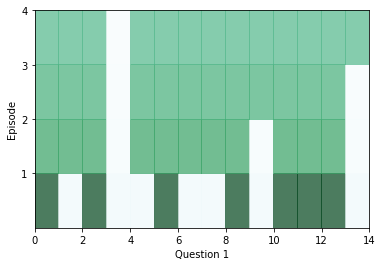

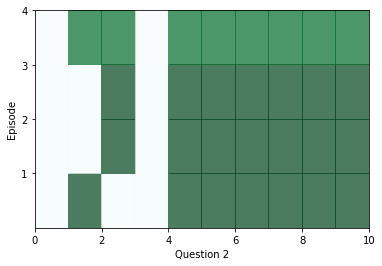

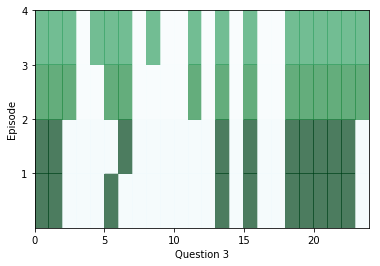

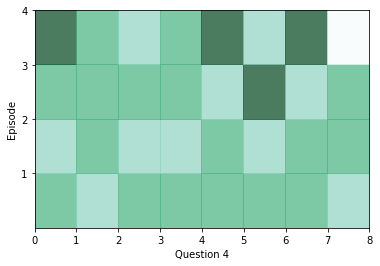

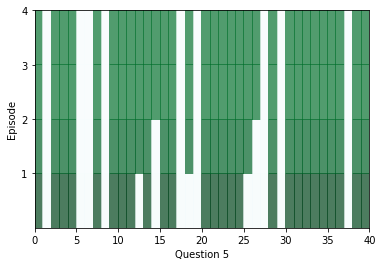

In [25]:
ancr = sess.run([corrbool,locs, total_loss, logits, facts_0s, w_1]+attends+
                [query, cs, question_module_outputs],feed_dict=validation_set)
a = ancr[0]
n = ancr[1]
cr = ancr[2]
attenders = np.array(ancr[6:-3]) 
faq = np.sum(ancr[4], axis=(-1,-2)) # Number of facts in each context

limit = 5
for question in range(min(limit, batch_size)):
    plt.yticks(range(passes,0,-1))
    plt.ylabel("Episode")
    plt.xlabel("Question "+str(question+1))
    pltdata = attenders[:,question,:int(faq[question]),0] 
    # Display only information about facts that actually exist, all others are 0
    pltdata = (pltdata - pltdata.mean()) / ((pltdata.max() - pltdata.min() + 0.001)) * 256
    plt.pcolor(pltdata, cmap=plt.cm.BuGn, alpha=0.7)
    plt.show()

In order to see what the answers for the above questions were, we can use the location of our distance score in the context as an index and see what word is at that index.

In [26]:
# Locations of responses within contexts
indices = np.argmax(n,axis=1)

# Locations of actual answers within contexts 
indicesc = np.argmax(a,axis=1)

for i,e,cw, cqa in list(zip(indices, indicesc, val_context_words, val_cqas))[:limit]:
    ccc = " ".join(cw)
    print("TEXT: ",ccc)
    print ("QUESTION: ", " ".join(cqa[3]))
    print ("RESPONSE: ", cw[i], ["Correct", "Incorrect"][i!=e])
    print("EXPECTED: ", cw[e])
    print()

('TEXT: ', 'fred took the apple there . bill travelled to the bathroom . jeff picked up the football there . jeff travelled to the bathroom . jeff journeyed to the bedroom . fred discarded the apple there . jeff discarded the football there . fred grabbed the apple there . mary got the milk there . mary went back to the hallway . fred passed the apple to mary . mary passed the apple to fred . fred handed the apple to mary . fred went to the office .')
('QUESTION: ', 'who gave the apple to mary ?')
('RESPONSE: ', 'jeff', 'Incorrect')
('EXPECTED: ', 'fred')
()
('TEXT: ', 'jeff journeyed to the garden . mary went back to the bedroom . jeff picked up the milk there . mary journeyed to the office . jeff moved to the hallway . jeff journeyed to the office . fred journeyed to the garden . jeff gave the milk to mary . mary handed the milk to bill . jeff moved to the hallway .')
('QUESTION: ', 'who did mary give the milk to ?')
('RESPONSE: ', 'fred', 'Incorrect')
('EXPECTED: ', 'bill')
()
('TEX

/home/sentisis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # This is added back by InteractiveShellApp.init_path()


Let's keep training! In order to get good results, you may have to train for a long period of time (on my home desktop, it took about one and a half hours), but you should eventually be able to reach very high accuracies (over 90%). Experienced users of Jupyter Notebook should note that at any time, you can interrupt training and still save the progress the network has made so far, as long as you keep the same tf.Session; this is useful if you want to visualize the attention and answers the network is currently giving.

In [28]:
train(training_iterations_count, batch_size)
print(np.mean(sess.run([corrects], feed_dict= prep_batch(final_test_data))[0]))

  0%|          | 1/1563 [00:25<11:05:54, 25.58s/it]

('Iter 0, Minibatch Loss= ', 0.67319787, 'Accuracy= ', 0.40546876)


  6%|▋         | 101/1563 [06:51<1:39:09,  4.07s/it]

('Iter 100, Minibatch Loss= ', 0.67318666, 'Accuracy= ', 0.521875)


 13%|█▎        | 201/1563 [13:07<1:28:57,  3.92s/it]

('Iter 200, Minibatch Loss= ', 0.67315525, 'Accuracy= ', 0.64453125)


 19%|█▉        | 301/1563 [19:25<1:21:24,  3.87s/it]

('Iter 300, Minibatch Loss= ', 0.67312634, 'Accuracy= ', 0.6796875)


 26%|██▌       | 401/1563 [25:32<1:14:00,  3.82s/it]

('Iter 400, Minibatch Loss= ', 0.6731004, 'Accuracy= ', 0.75390625)


 32%|███▏      | 501/1563 [31:50<1:07:29,  3.81s/it]

('Iter 500, Minibatch Loss= ', 0.67313254, 'Accuracy= ', 0.759375)


 38%|███▊      | 601/1563 [38:06<1:01:00,  3.81s/it]

('Iter 600, Minibatch Loss= ', 0.67309266, 'Accuracy= ', 0.8101562)


 45%|████▍     | 701/1563 [44:11<54:19,  3.78s/it]  

('Iter 700, Minibatch Loss= ', 0.67308587, 'Accuracy= ', 0.8359375)


 51%|█████     | 801/1563 [50:17<47:50,  3.77s/it]

('Iter 800, Minibatch Loss= ', 0.6730945, 'Accuracy= ', 0.846875)


 58%|█████▊    | 901/1563 [56:22<41:25,  3.75s/it]

('Iter 900, Minibatch Loss= ', 0.67306393, 'Accuracy= ', 0.86328125)


 64%|██████▍   | 1001/1563 [1:02:19<34:59,  3.74s/it]

('Iter 1000, Minibatch Loss= ', 0.6730591, 'Accuracy= ', 0.865625)


 70%|███████   | 1101/1563 [1:08:20<28:40,  3.72s/it]

('Iter 1100, Minibatch Loss= ', 0.6730503, 'Accuracy= ', 0.878125)


 77%|███████▋  | 1201/1563 [1:15:27<22:44,  3.77s/it]

('Iter 1200, Minibatch Loss= ', 0.6730327, 'Accuracy= ', 0.8929688)


 83%|████████▎ | 1301/1563 [1:23:42<16:51,  3.86s/it]

('Iter 1300, Minibatch Loss= ', 0.6730404, 'Accuracy= ', 0.90703124)


 90%|████████▉ | 1401/1563 [1:31:15<10:33,  3.91s/it]

('Iter 1400, Minibatch Loss= ', 0.67304957, 'Accuracy= ', 0.89765626)


 96%|█████████▌| 1501/1563 [1:39:01<04:05,  3.96s/it]

('Iter 1500, Minibatch Loss= ', 0.67303765, 'Accuracy= ', 0.9140625)


100%|██████████| 1563/1563 [1:43:40<00:00,  3.98s/it]


0.909


In [29]:
# Locations of responses within contexts
indices = np.argmax(n,axis=1)

# Locations of actual answers within contexts 
indicesc = np.argmax(a,axis=1)

for i,e,cw, cqa in list(zip(indices, indicesc, val_context_words, val_cqas))[:limit]:
    ccc = " ".join(cw)
    print("TEXT: ",ccc)
    print ("QUESTION: ", " ".join(cqa[3]))
    print ("RESPONSE: ", cw[i], ["Correct", "Incorrect"][i!=e])
    print("EXPECTED: ", cw[e])
    print()

('TEXT: ', 'fred took the apple there . bill travelled to the bathroom . jeff picked up the football there . jeff travelled to the bathroom . jeff journeyed to the bedroom . fred discarded the apple there . jeff discarded the football there . fred grabbed the apple there . mary got the milk there . mary went back to the hallway . fred passed the apple to mary . mary passed the apple to fred . fred handed the apple to mary . fred went to the office .')
('QUESTION: ', 'who gave the apple to mary ?')
('RESPONSE: ', 'jeff', 'Incorrect')
('EXPECTED: ', 'fred')
()
('TEXT: ', 'jeff journeyed to the garden . mary went back to the bedroom . jeff picked up the milk there . mary journeyed to the office . jeff moved to the hallway . jeff journeyed to the office . fred journeyed to the garden . jeff gave the milk to mary . mary handed the milk to bill . jeff moved to the hallway .')
('QUESTION: ', 'who did mary give the milk to ?')
('RESPONSE: ', 'fred', 'Incorrect')
('EXPECTED: ', 'bill')
()
('TEX

/home/sentisis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # This is added back by InteractiveShellApp.init_path()
